In [72]:
"""
1D Forward Simulation with User-Defined Waveforms
=================================================

For time-domain electromagnetic problems, the response depends strongly on the
souce waveforms. In this tutorial, we construct a set of waveforms of different
types and simulate the response for a halfspace. Many types of waveforms can
be constructed within *SimPEG.electromagnetics.time_domain_1d*. These include:
    
    - the unit step off waveform
    - a set of basic waveforms: rectangular, triangular, quarter sine, etc...
    - a set of system-specific waveforms: SkyTEM, VTEM, GeoTEM, etc...
    - fully customized waveforms


"""

#####################################################
# Import Modules
# --------------
#

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams.update({'font.size':16})

from SimPEG import maps
import SimPEG.electromagnetics.time_domain as tdem


#####################################################################
# Define Waveforms
# ----------------
# 
# Here, we define the set of waveforms that will be used to simulated the
# TEM response.
# 

# General waveform. This is a fully general way to define the waveform.
# The use simply provides times and the current.
def custom_waveform(t, tmax):
    out = np.cos(0.5*np.pi*(t-tmax)/(tmax+0.02))
    out[t>=tmax] = 1 + (t[t>=tmax] - tmax)/tmax
    return out

waveform_times = np.r_[np.linspace(-0.02, -0.011, 10), -np.logspace(-2, -6, 61), 0.]
waveform_current = custom_waveform(waveform_times, -0.0055)
general_waveform = tdem.sources.PiecewiseLinearWaveform(
        times=waveform_times, currents=waveform_current, 
        has_initial_fields=True
)
step_off_waveform = tdem.sources.StepOffWaveform()
#####################################################################
# Create Survey
# -------------
# 
# The waveform is a property of the source. So for each waveform, we will need
# to define a separate source object. For simplicity, all sources will be
# horizontal loops with a radius of 10 m.
# 

# Define a receiver list. In this case, we measure the vertical component of
# db/dt. Thus we only have a single receiver in the list.
receiver_location = np.array([0., 0., 30.])
receiver_orientation = "z"                    # "x", "y" or "z"
times_ch1 = np.logspace(-5.5, -2, 41)               # time channels
times_ch2 = np.logspace(-5.5, -2, 31) 

receiver_list_ch1 = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times_ch1, orientation=receiver_orientation
    )
]

receiver_list_ch2 = [
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times_ch2, orientation=receiver_orientation
    )
]


# Source properties. If you defined the true waveform (not normalized), the current amplitude
# should be set to 1. Otherwise you will be accounting for the maximum current
# amplitude twice!!! 
source_location = np.array([0., 0., 30.])  
source_radius = 10.
current_amplitude = 1.

source_list = []

    
# General Waveform
source_list.append(
    tdem.sources.CircularLoop(
        receiver_list=receiver_list_ch1, location=source_location,
        waveform=general_waveform, radius=source_radius, current=current_amplitude
    ),
)
source_list.append(    
    tdem.sources.CircularLoop(
        receiver_list=receiver_list_ch2, location=source_location,
        waveform=general_waveform, radius=source_radius, current=current_amplitude
    )

)

# Survey
survey = tdem.Survey(source_list)

###############################################
# Defining a 1D Layered Earth Model
# ---------------------------------
#
# Here, we define the layer thicknesses and electrical conductivities for our
# 1D simulation. If we have N layers, we define N electrical conductivity
# values and N-1 layer thicknesses. The lowest layer is assumed to extend to
# infinity.
#

# Layer thicknesses
thicknesses = np.array([40., 40.])
n_layer = len(thicknesses) + 1

# half-space physical properties
sigma_background = 1./100.
# physical property models
sigma_model = sigma_background * np.ones(n_layer)
# Define a mapping for conductivities
model_mapping = maps.IdentityMap(nP=n_layer)

#######################################################################
# Define the Forward Simulation and Predict Data
# ----------------------------------------------
#

# Define the simulation
simulation_1d = tdem.Simulation1DLayered(
    survey=survey, thicknesses=thicknesses, sigmaMap=model_mapping,
)

# Predict data for a given model
dpred_1d = simulation_1d.dpred(sigma_model)

In [73]:
from discretize import TreeMesh
from SimPEG import utils
import matplotlib.pyplot as plt
# import numpy as np
# import discretize
# def create_local_mesh(
#     src_location,
#     rx_location,
#     topo_location,
#     topo,
#     h = [10., 10., 5.],
#     x_core_lim = (-100., 100.),
#     y_core_lim = (-20., 20.),
#     padding_distance = [[2000., 2000.], [2000., 2000.], [2000., 2000.]]
#     ):

#     # TODO: All parameters used for generating this mesh should be input parameters
#     # Currently fixed for a specific case

#     xyz = np.vstack((rx_location, src_location))
#     x = np.linspace(x_core_lim[0], x_core_lim[1]) + src_location[0]
#     y = np.linspace(y_core_lim[0], y_core_lim[1]) + src_location[1]
#     dem = utils.ndgrid(x, y, np.r_[topo_location[2]])

#     mesh_local = discretize.utils.mesh_builder_xyz(
#         dem,
#         h,
#         padding_distance=padding_distance,
#         base_mesh=None,
#         depth_core=None,
#         expansion_factor=1.3,
#         mesh_type='tree'
#     )

#     mesh_local = discretize.utils.refine_tree_xyz(
#         mesh_local,
#         dem,
#         method='surface',
#         octree_levels=[5, 10, 10],
#         octree_levels_padding=None,
#         finalize=False,
#         min_level=0,
#         max_distance=np.inf,
#     )


#     mesh_local = discretize.utils.refine_tree_xyz(
#         mesh_local,
#         xyz,
#         method='radial',
#         octree_levels=[2, 0, 0],
#         octree_levels_padding=None,
#         finalize=True,
#         min_level=1,
#         max_distance=np.inf,
#     )

#     actv_local = utils.surface2ind_topo(mesh_local, topo)

#     return mesh_local, actv_local

In [74]:
from simpegaem import SimulationAEM, create_local_mesh

In [75]:
from SimPEG import utils
src_location = np.array([0, 0, 30])
rx_location = np.array([0, 0, 30])
topo_location = np.array([0, 0, 0])
x = np.linspace(-50, 50)
y = np.linspace(-50, 50)
z = np.array([0.])
topo = utils.ndgrid(x,y,z)
mesh_tree, ind_active_tree = create_local_mesh(
    src_location, rx_location, topo_location, topo,
    padding_distance=[[2000., 2000.], [2000., 2000.], [2000., 2000.]]
)

In [76]:
mesh_tree.n_cells

3600

In [77]:
from pymatsolver import PardisoSolver

In [78]:
def generate_time_steps(
    n_constant_steps=15, increase_rate=3, start_time_step=5e-7, n_per_step=5
):
    time_steps = []
    for i_step in range(n_constant_steps):
        ht = np.ones(n_per_step) * start_time_step*increase_rate**i_step
        time_steps.append(ht)
    print("t_min:{:.1e}, t_max:{:.1e}".format(start_time_step, np.sum(time_steps)))
    return np.hstack(time_steps)

In [79]:
simulation_3d = SimulationAEM(
    mesh=mesh_tree, survey=survey, sigmaMap=maps.IdentityMap(mesh_tree),
    solver=PardisoSolver
)
# dts = np.diff(np.logspace(-6, -1, 50))
# simulation_3d.time_steps = dts
simulation_3d.time_steps = generate_time_steps(n_constant_steps=14, increase_rate=2, start_time_step=5e-7, n_per_step=5)

t_min:5.0e-07, t_max:4.1e-02


In [80]:
times_ch1.max() + general_waveform.times.max() - general_waveform.times.min()

0.03

In [81]:
src = survey.source_list[0]

In [82]:
sigma = np.ones(mesh_tree.n_cells) * 1e-8
sigma[ind_active_tree] = sigma_background

In [83]:
%%time
d_off = simulation_3d.dpred(sigma)

Wall time: 1.56 s


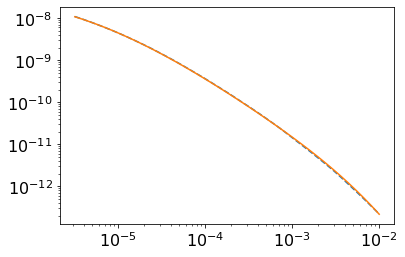

In [84]:
plt.loglog(times_ch1, -d_off[:times_ch1.size], '--')
plt.loglog(times_ch1, -dpred_1d[:times_ch1.size])

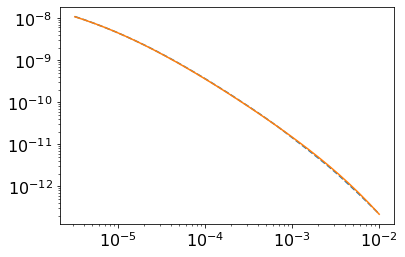

In [85]:
plt.loglog(times_ch2, -d_off[times_ch1.size:], '--')
plt.loglog(times_ch2, -dpred_1d[times_ch1.size:])

In [86]:
print ('rmse = {:.2e}'.format(np.sqrt((((d_off-dpred_1d)/d_off)**2).sum()/ d_off.size))) 

rmse = 2.85e-02
